### Programming_Assignment_2

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import os
import pathlib
from pathlib import Path
import numpy as np
from skimage import io
from skimage import filters
from skimage import exposure,color
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
image_folder = r'/Users/dinakarreddy/Desktop/Programming Assignment/Cropped'

In [4]:
from tqdm import tqdm
def angle(dx, dy):
    return np.mod(np.arctan2(dy, dx), np.pi)

def edge_histogram(image):
    im=angle(filters.sobel_h(image),filters.sobel_v(image))
    hist,_=exposure.histogram(im, nbins=36)
    return hist
inputs=[]
labels=[]
for index, dog in enumerate(tqdm(os.listdir(image_folder))):
    path = os.path.join(image_folder, dog)
    if os.path.isdir(path): 
        for file in os.listdir(path):
            file_path = os.path.join(path, file)
            if os.path.isfile(file_path):
                img = io.imread(file_path)
                gray_img = color.rgb2gray(img)
                hists = edge_histogram(gray_img)
                inputs.append(hists)
                labels.append(index)
inputs = np.array(inputs)
labels = np.array(labels)

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.38it/s]


In [5]:
len(inputs)

754

In [6]:
len(labels)

754

In [7]:
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.2,random_state=42,stratify=labels)

In [8]:
X_train

array([[ 729,  668,  580, ...,  581,  635,  691],
       [ 389,  356,  371, ...,  376,  345,  356],
       [1366,  471,  428, ...,  560,  514,  475],
       ...,
       [ 494,  484,  480, ...,  460,  457,  481],
       [ 485,  421,  451, ...,  438,  458,  453],
       [ 590,  633,  651, ...,  487,  543,  518]])

In [9]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
X_train

array([[ 0.57607493,  1.45442152,  1.01955653, ...,  1.08252643,
         1.21794712,  1.34952075],
       [-0.76545419, -1.11624116, -0.96260518, ..., -0.88921985,
        -1.19056607, -1.04492409],
       [ 3.0894692 , -0.16872126, -0.42201562, ...,  0.88054267,
         0.21301576, -0.1943601 ],
       ...,
       [-0.35115843, -0.06161031,  0.0711538 , ..., -0.08128479,
        -0.26038167, -0.15147452],
       [-0.3866695 , -0.58068643, -0.20388299, ..., -0.29288683,
        -0.25207645, -0.35160722],
       [ 0.02762626,  1.1660459 ,  1.69292246, ...,  0.17840863,
         0.45386708,  0.11298655]])

In [11]:
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k=[1,3,5,7,10,20]

def fold(s,knn):
    training,validation=[],[]
    for train_index, test_index in s.split(X_train, y_train):
        xtrain, xval = X_train[train_index], X_train[test_index]
        ytrain, yval = y_train[train_index], y_train[test_index]
        knn.fit(xtrain, ytrain)
        t_pred = knn.predict(xtrain)
        v_pred = knn.predict(xval)
        train_acc = accuracy_score(ytrain, t_pred)
        val_acc = accuracy_score(yval, v_pred)
        training.append(1-train_acc)
        validation.append(1-val_acc)
    return training,validation

def model_selection(k_vales,sf,skf):
    train_errors,val_errors,t_errors,v_errors=[],[],[],[]
    for n in k_vales:
        knn = KNeighborsClassifier(n)
        if sf:
            t,v=fold(sf,knn)
        train_errors.append(np.mean(t))
        val_errors.append(np.mean(v))
        if skf:
            st,sv=fold(skf,knn)
        t_errors.append(np.mean(st))
        v_errors.append(np.mean(sv))
    return train_errors,val_errors,t_errors,v_errors

skf1=StratifiedKFold(n_splits=5)
StandardTrain,StandardVal,StratifiedTrain,StratifiedVal = model_selection(k,KFold(n_splits=5),skf1)

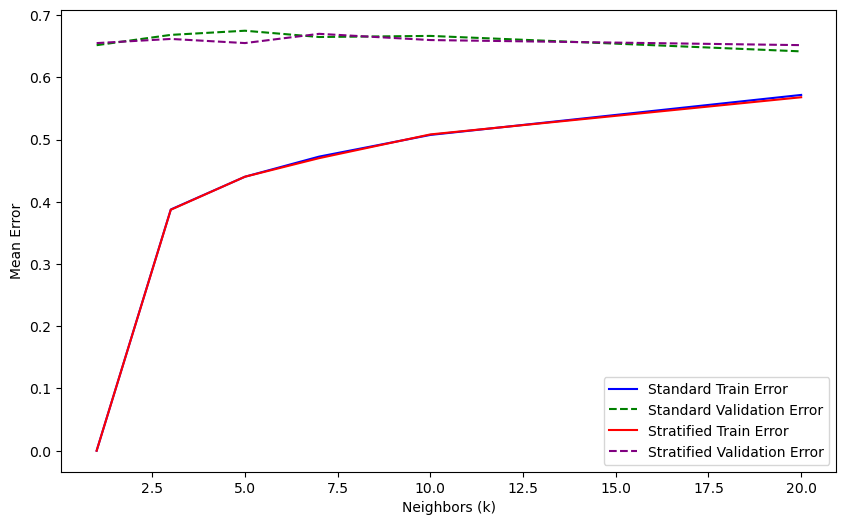

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(k, StandardTrain, linestyle='-', color='blue', label='Standard Train Error')
ax.plot(k, StandardVal, linestyle='--', color='green', label='Standard Validation Error')
ax.plot(k, StratifiedTrain, linestyle='-', color='red', label='Stratified Train Error')
ax.plot(k, StratifiedVal, linestyle='--', color='purple', label='Stratified Validation Error')
ax.set_xlabel('Neighbors (k)')
ax.set_ylabel('Mean Error')
ax.legend()
plt.show()

##### 1. Model complexity in relation to 'k' value :
In k-Nearest Neighbor (KNN) classifiers, the model complexity and k value are negatively correlated. Because the decision boundaries become more ragged and prone to catching noise in the data, a smaller value of k results in a more complex model. This is so because each data point's forecast is built using the precise values of the points that are closest to it. The model smooths out and the decision boundaries get easier as k rises.
Consequently, the model gets less complex as k increases and increases in complexity as k decreases.

##### 2. Overfitting and underfitting:
The value of k in the KNN algorithm is related to the error rate of the model. A small value of k could lead to overfitting as well as a big value of k can lead to underfitting. Overfitting imply that the model is well on the training data but has poor performance when new data is coming. Underfitting refers to a model that is not good on the training data and also cannot be generalized to predict new data.


##### Based on the provided test error of 0.6357615894039735 with the least stratified validation error occurring at 𝑘=5, we can infer that 𝑘 = 5 provides a good balance between model complexity and generalization performance, as it minimizes both overfitting and underfitting.

In [13]:
#test error 
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
print("Test Error with least stratified val error at k= 5 :" +str(1-(accuracy_score(y_test,pred))))

Test Error with least stratified val error at k= 5 :0.6357615894039735


In [14]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

### Decision Tree Classifier

In [15]:
dt_classifier = DecisionTreeClassifier(max_depth=10)

In [16]:
skf1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cm = []

DecisionTreeClassifier
mean-validation-accuracy: 0.30504132231404957
test-accuracy: 0.3841059602649007
f1-measure: 0.38566786251689633


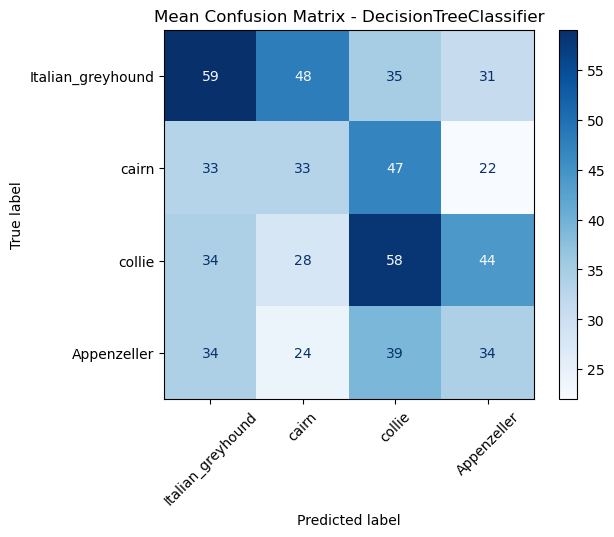

In [17]:
# DecisionTreeClassifier
print("DecisionTreeClassifier")
true, predict, valaccu = [], [], []
for train_index, test_index in skf1.split(X_train, y_train):
    xtrain, xval = X_train[train_index], X_train[test_index]
    ytrain, yval = y_train[train_index], y_train[test_index]
    dt_classifier.fit(xtrain, ytrain)
    pred = dt_classifier.predict(xval)
    true.extend(yval)
    predict.extend(pred)
    val_acc = accuracy_score(yval, pred)
    valaccu.append(val_acc)
print("mean-validation-accuracy: " + str(np.mean(valaccu)))
test_acc = accuracy_score(y_test, dt_classifier.predict(X_test))
print("test-accuracy: " + str(test_acc))
f1 = f1_score(y_test, dt_classifier.predict(X_test), average='weighted')
print("f1-measure: " + str(f1))
cm.append(confusion_matrix(true, predict))

# Calculate mean confusion matrix for DecisionTreeClassifier
mean_cm_dt = np.mean(cm, axis=0)

# Plot mean confusion matrix for DecisionTreeClassifier
cm_display = ConfusionMatrixDisplay(confusion_matrix=mean_cm_dt, display_labels=['Italian_greyhound', 'cairn', 'collie', 'Appenzeller'])
cm_display.plot(xticks_rotation=45, cmap=plt.cm.Blues)
plt.title("Mean Confusion Matrix - DecisionTreeClassifier")
plt.show()

### MLP Classifier

In [18]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(10, 10, 10))

MLPClassifier
mean-validation-accuracy: 0.35169421487603303
test-accuracy: 0.3576158940397351
f1-measure: 0.35157809523053873


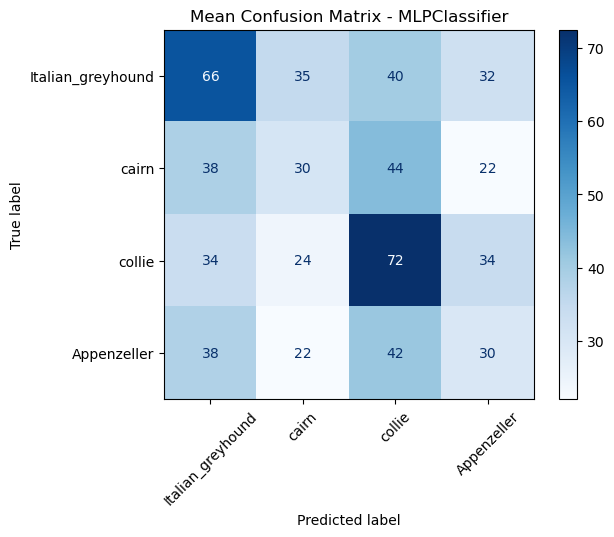

In [19]:
print("MLPClassifier")
true, predict, valaccu = [], [], []
for train_index, test_index in skf1.split(X_train, y_train):
    xtrain, xval = X_train[train_index], X_train[test_index]
    ytrain, yval = y_train[train_index], y_train[test_index]
    mlp_classifier.fit(xtrain, ytrain)
    pred = mlp_classifier.predict(xval)
    true.extend(yval)
    predict.extend(pred)
    val_acc = accuracy_score(yval, pred)
    valaccu.append(val_acc)
print("mean-validation-accuracy: " + str(np.mean(valaccu)))
test_acc = accuracy_score(y_test, mlp_classifier.predict(X_test))
print("test-accuracy: " + str(test_acc))
f1 = f1_score(y_test, mlp_classifier.predict(X_test), average='weighted')
print("f1-measure: " + str(f1))
cm.append(confusion_matrix(true, predict))

# Calculate mean confusion matrix for MLPClassifier
mean_cm_mlp = np.mean(cm, axis=0)

# Plot mean confusion matrix for MLPClassifier
cm_display = ConfusionMatrixDisplay(confusion_matrix=mean_cm_mlp, display_labels=['Italian_greyhound', 'cairn', 'collie', 'Appenzeller'])
cm_display.plot(xticks_rotation=45, cmap=plt.cm.Blues)
plt.title("Mean Confusion Matrix - MLPClassifier")
plt.show()

### Random Forest Classifier

In [20]:
rf_classifier = RandomForestClassifier()

RandomForestClassifier
mean-validation-accuracy: 0.3847382920110193
test-accuracy: 0.32450331125827814
f1-measure: 0.3106107321745915


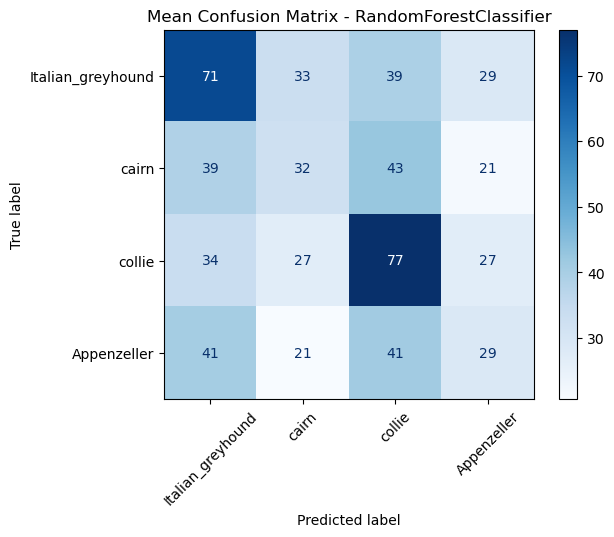

In [21]:
print("RandomForestClassifier")
true, predict, valaccu = [], [], []
for train_index, test_index in skf1.split(X_train, y_train):
    xtrain, xval = X_train[train_index], X_train[test_index]
    ytrain, yval = y_train[train_index], y_train[test_index]
    rf_classifier.fit(xtrain, ytrain)
    pred = rf_classifier.predict(xval)
    true.extend(yval)
    predict.extend(pred)
    val_acc = accuracy_score(yval, pred)
    valaccu.append(val_acc)
print("mean-validation-accuracy: " + str(np.mean(valaccu)))
test_acc = accuracy_score(y_test, rf_classifier.predict(X_test))
print("test-accuracy: " + str(test_acc))
f1 = f1_score(y_test, rf_classifier.predict(X_test), average='weighted')
print("f1-measure: " + str(f1))
cm.append(confusion_matrix(true, predict))

# Calculate mean confusion matrix for RandomForestClassifier
mean_cm_rf = np.mean(cm, axis=0)

# Plot mean confusion matrix for RandomForestClassifier
cm_display = ConfusionMatrixDisplay(confusion_matrix=mean_cm_rf, display_labels=['Italian_greyhound', 'cairn', 'collie', 'Appenzeller'])
cm_display.plot(xticks_rotation=45, cmap=plt.cm.Blues)
plt.title("Mean Confusion Matrix - RandomForestClassifier")
plt.show()

###### Based on the 3 confusion matrices, Confusion matrix obtained by Random forest classifier is the best. Because we observed sum of its diagonal is greater compared to other two methods i.e Random forest predicted more correct combinations compared to rest of the two.

###### Mean validation is best in Random forest

##### Test accuracy is best in Decision Tree classifier

##### F1-measure is best in Decision Tree classifier

References:
1. Confusion matrix display: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
2. Decision tree classifier: https://scikit-learn.org/stable/modules/tree.html#classification
3. Neural Networks(MLP): https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
4. Random forest classifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
5. cross validation: https://scikit-learn.org/stable/modules/cross_validation.html
6. Model complexity: https://medium.com/@diegotronics/model-complexity-in-machine-learning-59b355202a29#:~:text=Model%20complexity%20for%20KNN&text=If%20k%20increases%20the%20decision,relationships%20within%20the%20data%20set.
7. underfitting and overfitting:https://www.codecademy.com/learn/introduction-to-supervised-learning-skill-path/modules/k-nearest-neighbors-skill-path/cheatsheet